In [65]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
from IPython.display import clear_output  # 引入 clear_output
# torch.manual_seed(seed=42)  

os.makedirs("fun_images", exist_ok=True)


In [66]:
layer_num=3
hidden_num=64

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [67]:
def potential(x):
    poten=x*torch.sin(torch.pi*x/2.5)*10+x**4/25
    return poten

In [ ]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
La=-10
Lb =10
L=Lb-La  # domain length
N = 3000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)

en_num=200
extend_num=0
epoch=12000
lr=0.01
# 先给出固定的矩阵元素
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap


In [69]:
# 计算初始的本征值
V_diag_real=potential(grid)

In [70]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=20,threshold=1e-4)
loss_fn=nn.MSELoss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    V_diag_real=potential(grid)
    val_loss=loss_fn(V_diag,V_diag_real)
    val_loss.backward()
    optimizer.step()
    
    loss_list.append(val_loss.item())
    
    if i%10==0:
        # clear_output(wait=True)
        print(f'epoch:{i},val_loss:{val_loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    
    scheduler.step(val_loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
print('terminal epoch: ',i+1)


epoch:0,val_loss:13787.5556640625,time:0.007832765579223633,lr:0.01
epoch:10,val_loss:3642.81201171875,time:0.04716968536376953,lr:0.01
epoch:20,val_loss:2816.1298828125,time:0.0841827392578125,lr:0.01
epoch:30,val_loss:1750.866943359375,time:0.12235903739929199,lr:0.01
epoch:40,val_loss:1072.8643798828125,time:0.16065764427185059,lr:0.01
epoch:50,val_loss:997.4871826171875,time:0.19824624061584473,lr:0.01
epoch:60,val_loss:974.4927368164062,time:0.23606467247009277,lr:0.01
epoch:70,val_loss:952.7648315429688,time:0.27411842346191406,lr:0.01
epoch:80,val_loss:933.7986450195312,time:0.31114697456359863,lr:0.01
epoch:90,val_loss:906.9284057617188,time:0.3478834629058838,lr:0.01
epoch:100,val_loss:865.608154296875,time:0.38544273376464844,lr:0.01
epoch:110,val_loss:792.1576538085938,time:0.4222865104675293,lr:0.01
epoch:120,val_loss:990.0709228515625,time:0.46096301078796387,lr:0.01
epoch:130,val_loss:653.6810913085938,time:0.5045421123504639,lr:0.01
epoch:140,val_loss:378.4149475097656,t

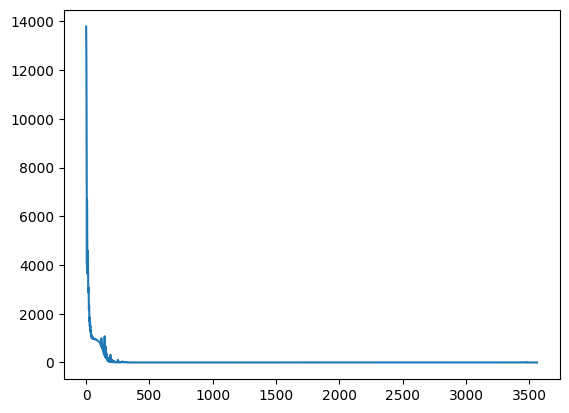

In [71]:
plt.plot(loss_list)
plt.show()

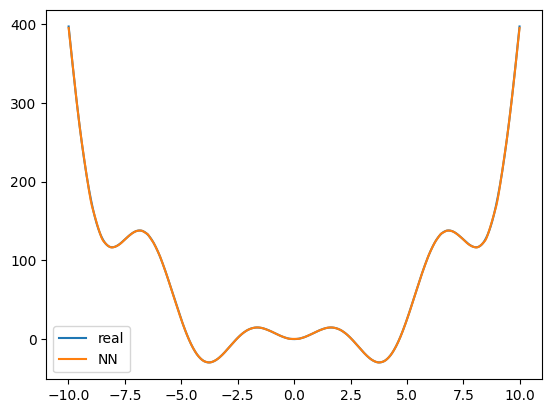

In [72]:
La=-10
Lb =10
L=Lb-La  # domain length
N = 2000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_NN=model(grid)
V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid)
real_poten=real_poten.cpu().detach().numpy()
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.legend()
plt.show()

In [73]:
# os.makedirs(f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
# torch.save(V_NN,f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}/V_NN_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')

In [74]:
error=V_NN-real_poten
mean_error=np.mean(np.abs(error))
max_error=np.max(np.abs(error))
print('mean_error:',mean_error)
print('max_error:',max_error)

mean_error: 0.1914282
max_error: 2.1986542
